# Image alignment

In this task, you will have to solve two image alignment problems: channel processing and face alignment. You can get **10 points** implementing all the passed functions (7.5 for the first part and 2.5 for the second one).

# Image channels processing and alignment (7.5 points)

## Problem review

Sergey Prokudin-Gorsky was the first color photographer in Russia, who made the color portrait of Leo Tolstoy. Each of his photographs is three black-and-white photo plates, corresponding to red, green, and blue color channels. Currently, the collection of his pictures is situated in the U.S. Library of Congress, the altered versions have proliferated online. In this task, you should make a programme which will align the images from the Prokudin-Gorsky plates and learn the basic image processing methods.

*The input image and the result of the alignment:*
<img src="http://cdn1.savepice.ru/uploads/2017/7/31/8e68237bfd49026d137f59283db18b29-full.png">

In [1]:
%pylab inline
import matplotlib.pyplot as plt 
import numpy as np

Populating the interactive namespace from numpy and matplotlib


## Problem description

#### Input image loading

The input image is the set of 3 plates, corresponding to B, G, and R channels (top-down). You should implement the function $\tt{load}$\_$\tt{data}$ that reads the data and returns the list of images of plates.
$\tt{dir}$\_$\tt{name}$ is the path to the directory with plate images. If this directory is located in the same directory as this notebook, then default arguments can be used.

In [2]:
from PIL import Image
import os

def load_data(dir_name = 'plates'):
    
    """ Your implementation """     

    files=os.listdir(dir_name)
    image_list = [plt.imread(dir_name+"/"+img).mean(axis = 2) for img in files]
    return image_list

plates = load_data()

In [3]:
#plt.imshow(plates[0].shape)

The dataset is a list of 2-dimensional arrays.

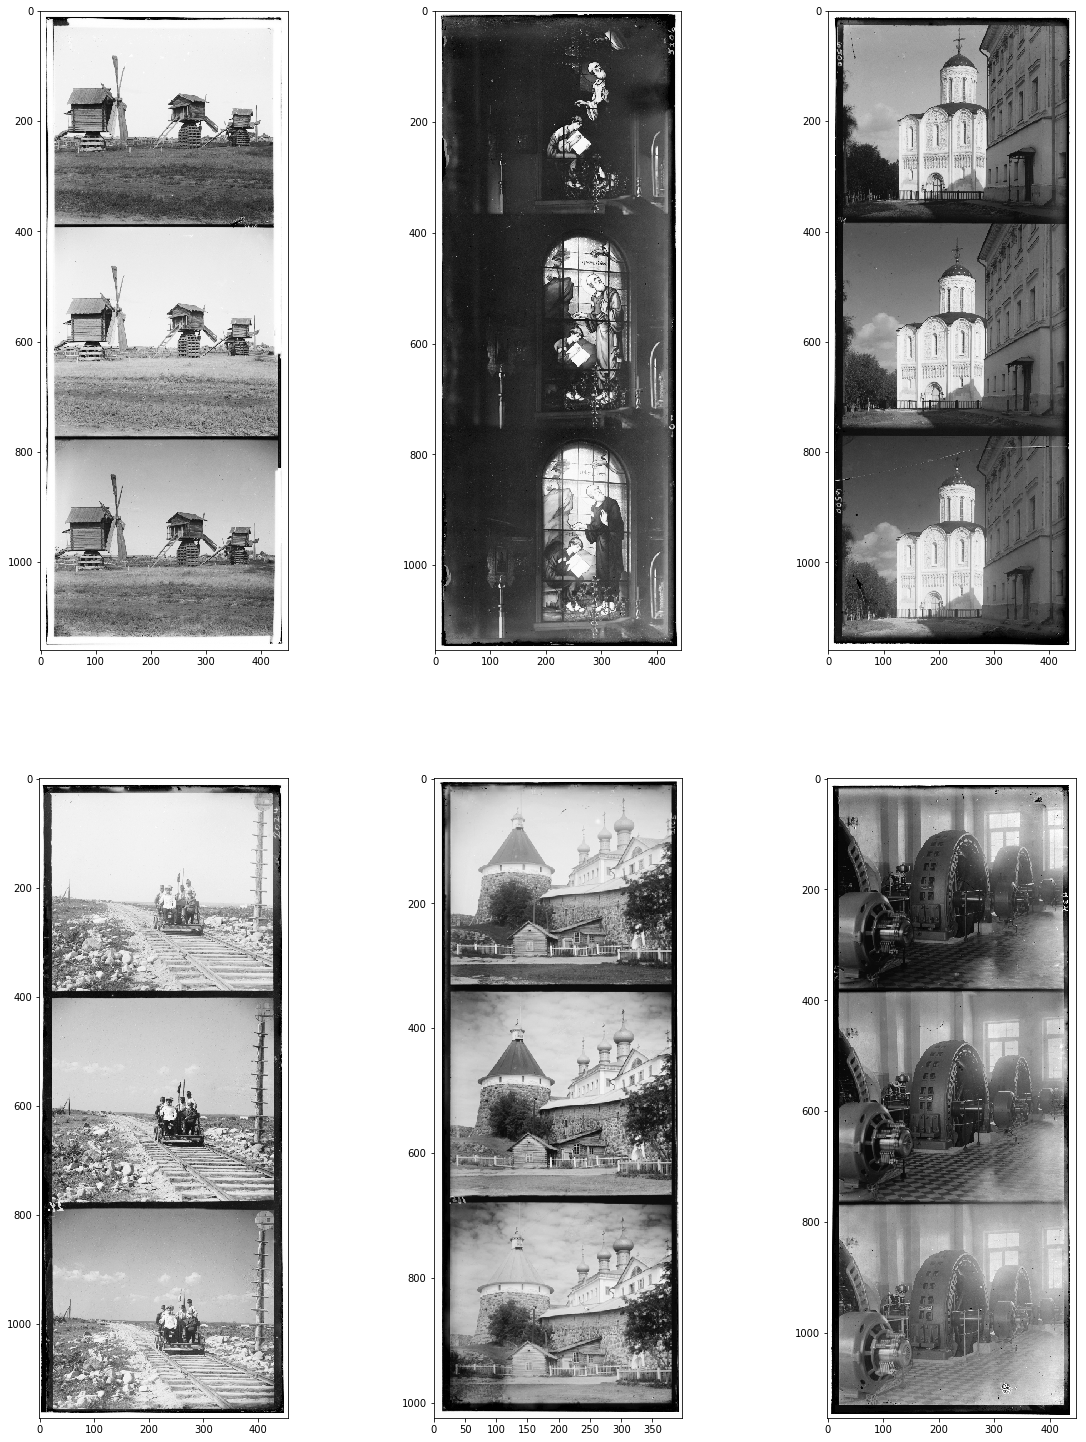

In [4]:
# The auxiliary function `visualize()` displays the images given as argument.
def visualize(imgs, format=None):
    plt.figure(figsize=(20, 40))
    for i, img in enumerate(imgs):
        if img.shape[0] == 3:
            img = img.transpose(1,2,0)
        plt_idx = i+1
        plt.subplot(3, 3, plt_idx)    
        plt.imshow(img, cmap=format)
    plt.show()

visualize(plates, 'gray')

#### The borders removal (1.5 points)
It is worth noting that there is a framing from all sides in most of the images. This framing can appreciably worsen the quality of channels alignment. Here, we suggest that you find the borders on the plates using Canny edge detector, and crop the images according to these edges. The example of using Canny detector implemented in skimage library can be found [here](http://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html).<br>

The borders can be removed in the following way:
* Apply Canny edge detector to the image.
* Find the rows and columns of the frame pixels. 
For example, in case of upper bound we will search for the row in the neighborhood of the upper edge of the image (e.g. 5% of its height). For each row let us count the number of edge pixels (obtained using Canny detector) it contains. Having these number let us find two maximums among them. Two rows corresponding to these maximums are edge rows. As there are two color changes in the frame (firstly, from light scanner background to the dark tape and then from the tape to the image), we need the second maximum that is further from the image border. The row corresponding to this maximum is the crop border. In order not to find two neighboring peaks, non-maximum suppression should be implemented: the rows next to the first maximum are set to zero, and after that, the second maximum is searched for.

#### Canny detector implementation (2.5 points)
You can write your own implementation of Canny edge detector to get extra points. <br>

Canny detection algorithm:
1. *Noise reduction.* To remove noise, the image is smoothed by Gaussian blur with the kernel of size $5 \times 5$ and $\sigma = 1.4$. Since the sum of the elements in the Gaussian kernel equals $1$, the kernel should be normalized before the convolution. <br><br>

2. *Calculating gradients.* When the image $I$ is smoothed, the derivatives $I_x$ and $I_y$ w.r.t. $x$ and $y$ are calculated. It can be implemented by convolving $I$ with Sobel kernels $K_x$ and $K_y$, respectively: 
$$ K_x = \begin{pmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{pmatrix}, K_y = \begin{pmatrix} 1 & 2 & 1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{pmatrix}. $$ 
Then, the magnitude $G$ and the slope $\theta$ of the gradient are calculated:
$$ |G| = \sqrt{I_x^2 + I_y^2}, $$
$$ \theta(x,y) = arctan\left(\frac{I_y}{I_x}\right)$$<br><br>

3. *Non-maximum suppression.* For each pixel find two neighbors (in the positive and negative gradient directions, supposing that each neighbor occupies the angle of $\pi /4$, and $0$ is the direction straight to the right). If the magnitude of the current pixel is greater than the magnitudes of the neighbors, nothing changes, otherwise, the magnitude of the current pixel is set to zero.<br><br>

4. *Double threshold.* The gradient magnitudes are compared with two specified threshold values, the first one is less than the second. The gradients that are smaller than the low threshold value are suppressed; the gradients higher than the high threshold value are marked as strong ones and the corresponding pixels are included in the final edge map. All the rest gradients are marked as weak ones and pixels corresponding to these gradients are considered in the next step.<br><br>

5. *Edge tracking by hysteresis.* Since a weak edge pixel caused from true edges will be connected to a strong edge pixel, pixel $w$ with weak gradient is marked as edge and included in the final edge map if and only if it is involved in the same blob (connected component) as some pixel $s$ with strong gradient. In other words, there should be a chain of neighbor weak pixels connecting $w$ and $s$ (the neighbors are 8 pixels around the considered one). You are welcome to make up and implement an algorithm that finds all the connected components of the gradient map considering each pixel only once.  After that, you can decide which pixels will be included in the final edge map (this algorithm should be single-pass, as well).

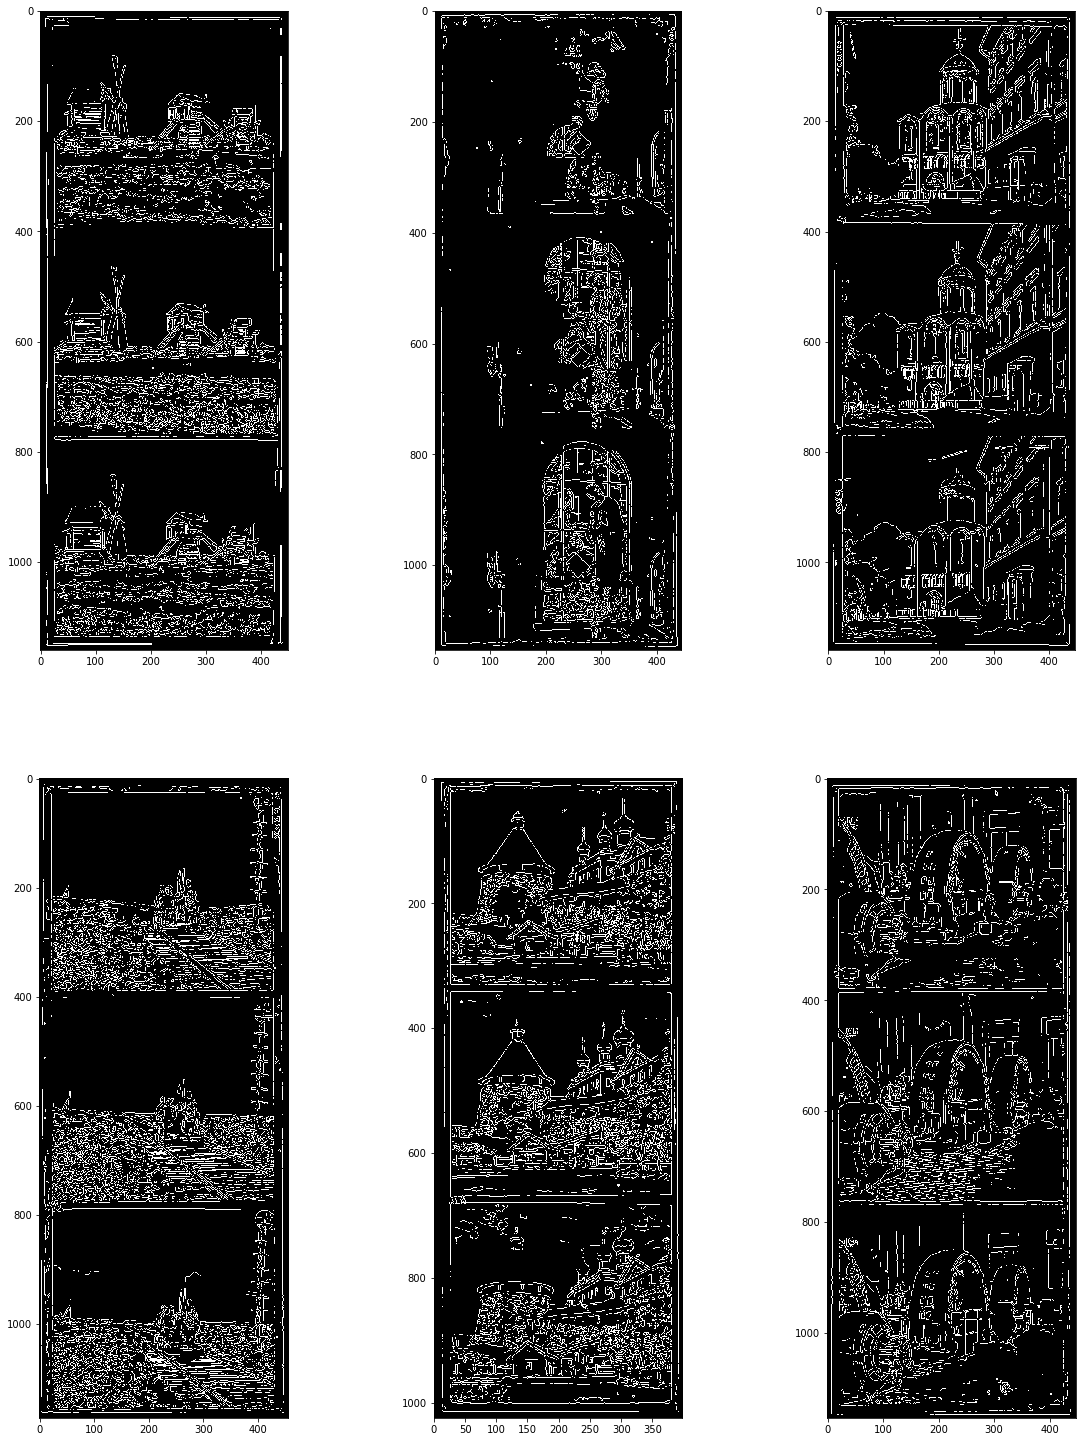

In [5]:
#################################################################
# TODO: implement Canny detector yourself.                      #
#       You can use methods from scipy.ndimage if you need.     #
#################################################################
from skimage.feature import canny
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy import signal
import math


def Canny_detector(img):
    
    #1. Noise reduction 
    gaussian_filter  = np.random.normal(0,1.4,size=(5,5))
    gaussian_filter = gaussian_filter/gaussian_filter.sum()
    smoothed = signal.convolve2d(img, gaussian_filter, mode='same')
    
    #2. Calculating gradients
    Kx = np.array([[-1, 0, 1],[-2,0,2],[-1,0,1]])
    Ky = np.array([[1, 2, 1],[0,0,0],[-1,-2,-1]])
        
    Ix = signal.convolve2d(smoothed, Kx, mode='valid')
    Iy = signal.convolve2d(smoothed, Ky, mode='valid')
    
    G = np.sqrt(np.square(Ix) + np.square(Iy))
  #  Theta = np.arctan(Ix/ Iy)
    
    
    #3. Non-maximum suppression
#    for x in range(len(img)):
#        for y in range(len(img[0])):
#            if ()
#            break
    
   # print(G)
   # print(Teta)
    
    #4. Double threshold
   # edge_map = np.empty_like(img)
   # for x in range(len(G)):
   #     for y in range(len(G[0])):
   #        if (G[x,y]<low_threshold):
   #            G[x,y] = 0
    #        elif (G[x,y]>high_threshold):
    #            edge_map[x,y] = 255

    #5. Edge tracking by hysteresis
    # Not in one pass!            
   # for x in range(len(G)):
   #     for y in range(len(G[0])):
   #         if (G[x,y] != 0 and edge_map[x,y] == 0):
    #            if (edge_map[x-1:x+1, y-1:y+1].sum() > 0):
    #                edge_map[x,y] = 1
            

    """ Your implementation instead of skimage """     
    return canny(img)


canny_imgs = []
for img in plates:
    canny_img = Canny_detector(img)
    canny_imgs.append(canny_img)
    
visualize(canny_imgs, 'gray')

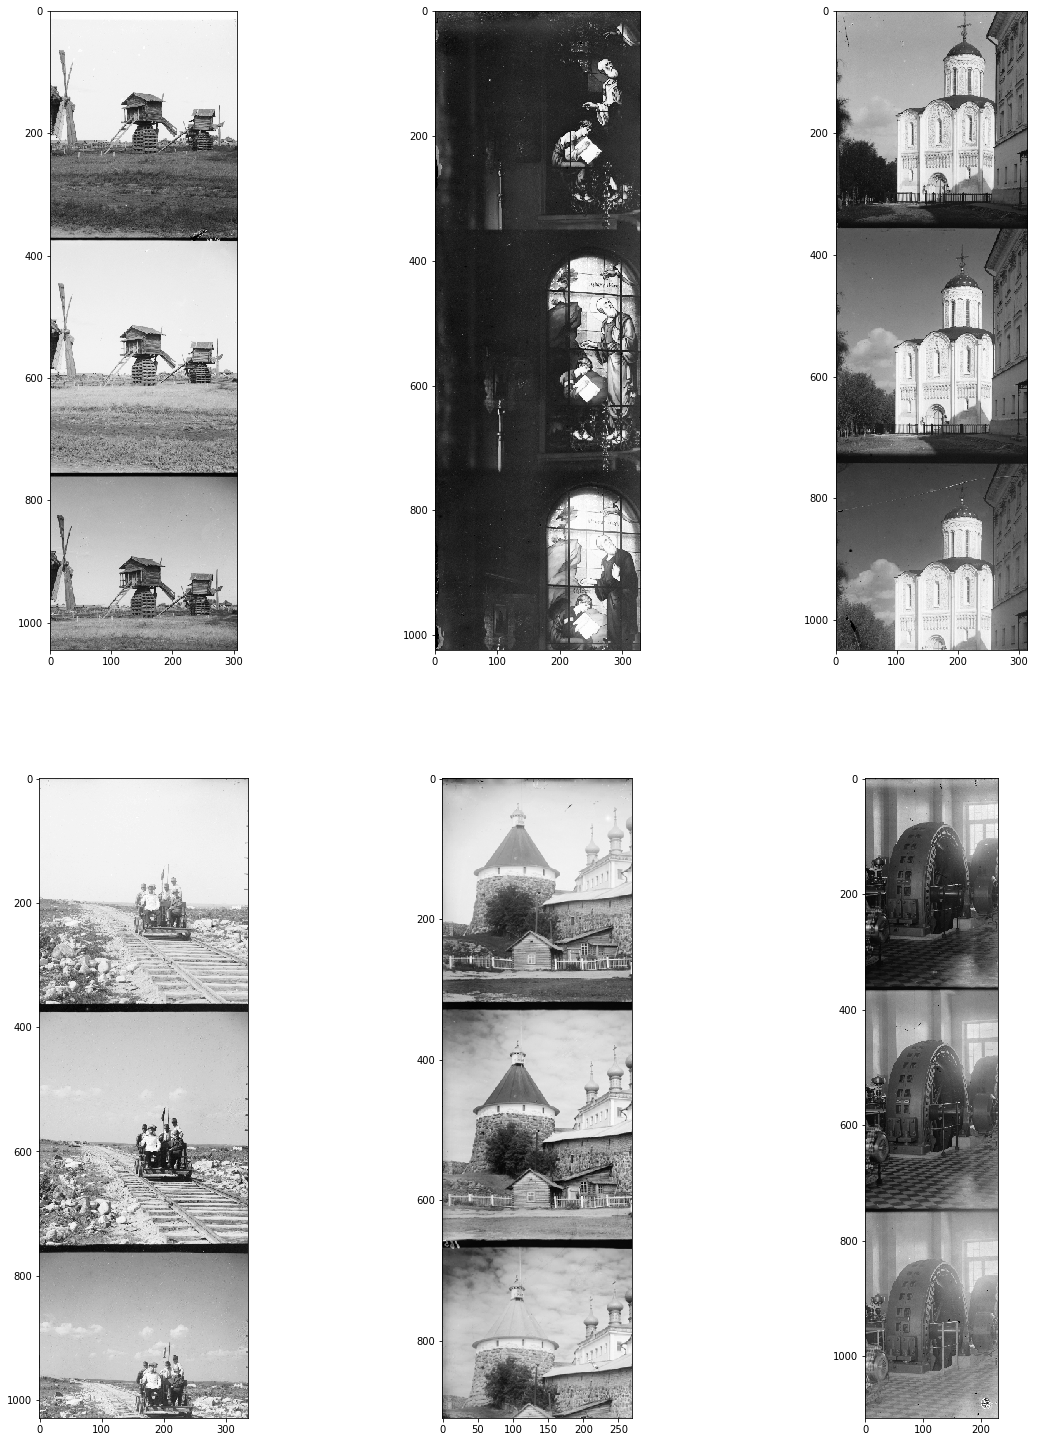

In [6]:
#################################################################
# TODO: Implement the removal of the tape borders using         #
#       the output of Canny edge detector ("canny_img" list)    #
#################################################################
def remove_borders(img, canny_img):
    """ Your implementation instead of the following one"""   
    dx = int(len(img) * 0.1) 
    dy = dx

    x = canny_img.sum(axis=0)
    mask_max = np.where(x > np.percentile(x, 90))[0]
    x_left = max(mask_max[mask_max <= dx])
    x_right = min(mask_max[mask_max >= img.shape[1] - dx])
        
    y = canny_img.sum(axis=1)
    mask_max = np.where(y > np.percentile(y, 90))[0]
    y_top = max(mask_max[mask_max <= dy])
    y_bottom = min(mask_max[mask_max >= len(img) - dy])

    return img[y_top: y_bottom, x_left: x_right]


cropped_imgs = []
#crop borders
for i, img in enumerate(plates):
    cropped_imgs.append(remove_borders(img, canny_imgs[i]))

visualize(cropped_imgs, 'gray')


#### Channels separation  (0.5 points)

The next step is to separate the image into three channels (B, G, R) and make one colored picture. To get channels, you can divide each plate into three equal parts.

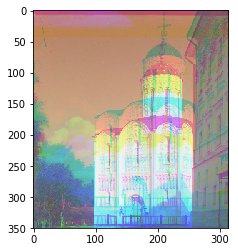

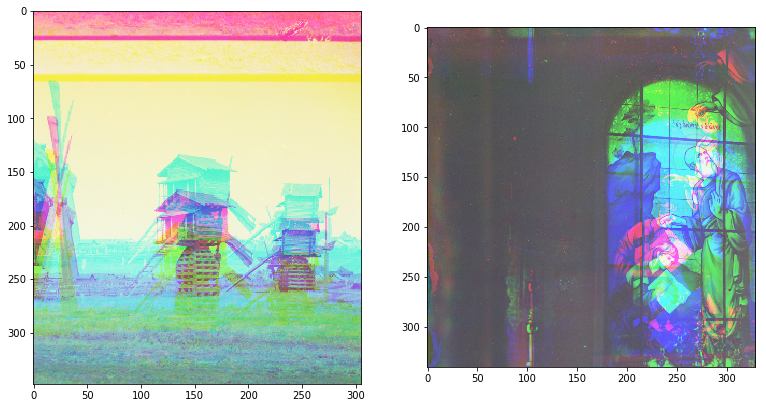

In [7]:
#################################################################
# TODO: implement the function impose_components transforming   #
#       cropped black-and-white images cropped_imgs             #
#       into the list of RGB images rgb_imgs                    #
#################################################################
def impose_components(img):
    """ Your implementation """   
    height = len(img) // 3 
        
    rgb_img =  np.zeros((height, img.shape[1], 3)) 
    rgb_img[:,:,0] = img[0 : height, :]
    rgb_img[:,:,1] = img[height : height*2, :]
    rgb_img[:,:,2] = img[2*height : height*3, :]

    plt.imshow(rgb_img)
    return rgb_img

rgb_imgs = []
for idx, cropped_img in enumerate(cropped_imgs):
    rgb_img = impose_components(cropped_img)
    plt.imshow(rgb_img)
    if (idx > 1):
        break
    rgb_imgs.append(rgb_img)

visualize(rgb_imgs)

#### Search for the best shift for channel alignment (1 point for metrics implementation + 2 points for channel alignment)

In order to align two images, we will shift one image relative to another within some limits (e.g. from $-15$ to $15$ pixels). For each shift, we can calculate some metrics in the overlap of the images. Depending on the metrics, the best shift is the one the metrics achieves the greatest or the smallest value for. We suggest that you implement two metrics and choose the one that allows to obtain the better alignment quality:

* *Mean squared error (MSE):*<br><br>
$$ MSE(I_1, I_2) = \dfrac{1}{w * h}\sum_{x,y}(I_1(x,y)-I_2(x,y))^2, $$<br> where *w, h* are width and height of the images, respectively. To find the optimal shift you should find the minimum MSE over all the shift values.
    <br><br>
* *Normalized cross-correlation (CC):*<br><br>
    $$
    I_1 \ast I_2 = \dfrac{\sum_{x,y}I_1(x,y)I_2(x,y)}{\sum_{x,y}I_1(x,y)\sum_{x,y}I_2(x,y)}.
    $$<br>
    To find the optimal shift you should find the maximum CC over all the shift values.

In [8]:
#################################################################
# TODO: implement the functions mse и cor calculating           #
#       mean squared error and normalized cross-correlation     #
#       for two input images, respectively (1 point)            #
#################################################################
def mse(X, Y):
    """ Your implementation """    
    return np.sum(np.square(X-Y)) / (len(X[0]) * len(X))

def cor(X, Y):
    """ Your implementation """     
    return np.sum(np.square(np.matmul(X,Y))) / np.mult(np.sum(X),np.sum(Y))


AttributeError: 'NoneType' object has no attribute 'shape'

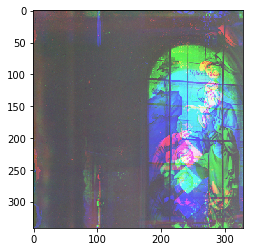

<Figure size 1440x2880 with 0 Axes>

In [9]:
#################################################################
# TODO: implement the algorithm to find the best channel        #
#       shift and the alignment. Apply this algorithm for       #
#       rgb_imgs processing and get the final list of colored   #
#       pictures. These images will be used for the evaluation  #
#       of the quality of the whole algorithm.  (2 points)      #
#                                                               #
#       You can use the following interface or write your own.  #
#################################################################

def get_best_shift(channel1, channel2, metrics):
    """ Your implementation """     
    shift_pixels = 15
    
    best_error = 10000
    
    for x in range(-shift_pixels, shift_pixels):
        for y in range(-shift_pixels, shift_pixels):
            shifted_channel2 = ndimage.shift(channel2, (x,y))
            
            if metrics == 'mse':
                error = mse(channel1, shifted_channel2)
            elif metrics == 'cor':
                error = cor(channel1, shifted_channel2)
            
            if error < best_error:
                best_error = error
                best_shift = (x,y)
            
    return ndimage.shift(channel2, best_shift)
            


def get_best_image(rgb_img):
    """ Your implementation """
    
    B = rgb_img[:,:,0]
    G = rgb_img[:,:,1]
    R = rgb_img[:,:,2]
    best_G = get_best_shift(B,G, "mse")
    best_R = get_best_shift(B, R, "mse")
    rgb_img[:,:,1] = best_G
    rgb_img[:,:,2] = best_R
    plt.imshow(rgb_img)

final_imgs = []
for img in rgb_imgs:
    final_img = get_best_image(img)
    final_imgs.append(final_img)
    #break

visualize(final_imgs)

# Face Alignment (2.5 points)

In this task, you have to implement face normalization and alignment. Most of the face images deceptively seem to be aligned, but since many face recognition algorithms are very sensitive to shifts and rotations, we need not only to find a face on the image but also normalize it. Besides, the neural networks usually used for recognition have fixed input size, so, the normalized face images should be resized as well.

There are six images of faces you have to normalize. In addition, you have the coordinates of the eyes in each of the pictures. You have to rotate the image so that the eyes are on the same height, crop the square box containing the face and transform it to the size $224\times 224.$ The eyes should be located symmetrically and in the middle of the image (on the height).

Here is an example of how the transformation should look like.

<img src = "https://cdn1.savepice.ru/uploads/2017/12/13/286e475ef7a4f4e59005bcf7de78742f-full.jpg">

#### Get data
You get the images and corresponding eyes coordinates for each person. You should implement the  function $\tt{load}$\_$\tt{faces}$\_$\tt{and}$\_$\tt{eyes}$ that reads the data and returns two dictionaries: the dictionary of images and the dictionary of eyes coordinates. Eyes coordinates is a list of two tuples $[(x_1,y_1),(x_2,y_2)]$.
Both dictionaries should have filenames as the keys.

$\tt{dir}$\_$\tt{name}$ is the path to the directory with face images, $\tt{eye}$\_$\tt{path}$ is the path to .pickle file with eyes coordinates. If these directory and file are located in the same directory as this notebook, then default arguments can be used.

In [10]:
ls 'faces_imgs/'

1.jpg  2.jpg  3.jpg  4.jpg  5.jpg  6.jpg


In [39]:
def load_faces_and_eyes(dir_name = 'faces_imgs', eye_path = './eyes.pickle'):
    """ Your implementation """     
    
    files = os.listdir(dir_name)
    faces_list = [plt.imread(dir_name+"/"+img) for img in files]
    eyes_coord = np.load(eye_path)
    
    faces = {}
    #eyes = {}
    for idx, image in enumerate(faces_list):
        faces[files[idx]] = faces_list[idx]
        #(x1, y1), (x2, y2) = eyes_coord[files[idx]]
        #eyes[files[idx]] = faces_list[idx][y1 : y2, x1 : x2]
    #plt.imshow(eyes[files[3]])    

    return faces, eyes_coord

    
faces, eyes = load_faces_and_eyes()

Here is how the input images look like:

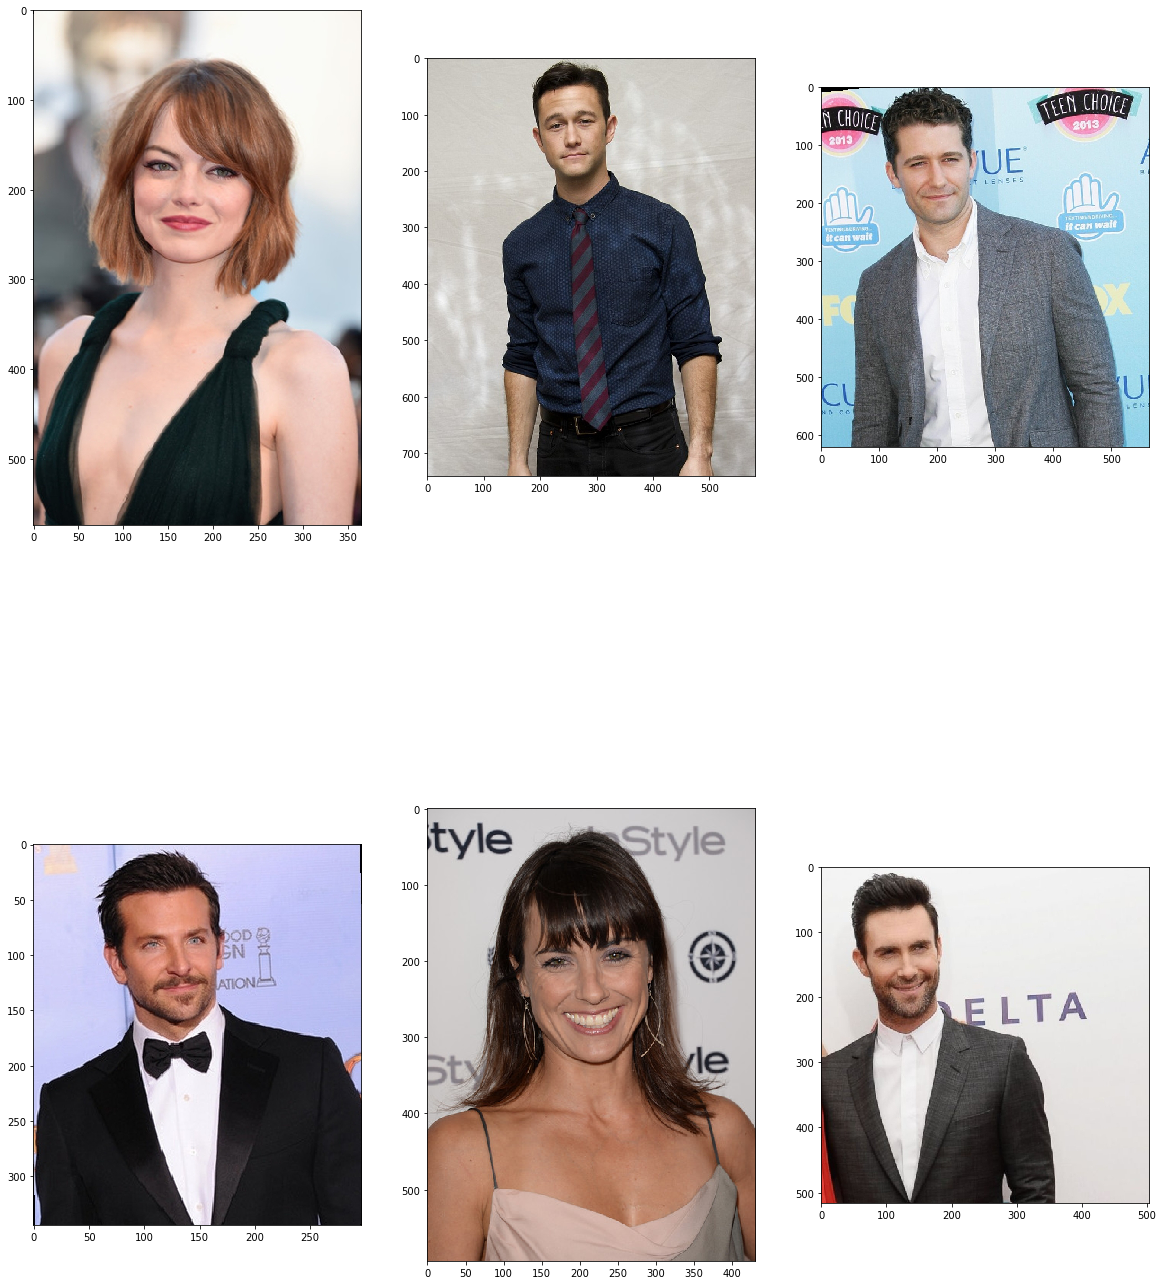

In [40]:
visualize(faces.values())

In [41]:
#visualize(eyes.values())
eyes

{'2.jpg': [(108, 92), (145, 88)],
 '6.jpg': [(169, 133), (222, 126)],
 '4.jpg': [(146, 174), (211, 180)],
 '5.jpg': [(230, 121), (279, 114)],
 '3.jpg': [(173, 201), (246, 193)],
 '1.jpg': [(104, 132), (152, 124)]}

You may make the transformation using your own algorithm or by the following steps:
1. Find the angle between the segment connecting two eyes and horizontal line;
2. Rotate the image;
3. Find the coordinates of the eyes on the rotated image
4. Find the width and height of the box containing the face depending on the eyes coordinates
5. Crop the box and resize it to $224\times224$

In [42]:
#################################################################
# TODO: implement the function transform_face that rotates      #
#       the image so that the eyes have equal ordinate,         #
#       crops the square box containing face and resizes it.    #
#       You can use methods from skimage library if you need.   #
#       (2.5 points)                                              #
#################################################################
from scipy.misc import imresize
import numpy.linalg as la
import cv2
import imutils

def find_angle(ref, vector):
    cosang = np.dot(ref, vector)
    sinang = la.norm(np.cross(ref, vector))
    return np.arctan2(sinang, cosang)
    
def compute_new_coord(x1,x2, y1, y2, center, angle):
    (cx, cy) = center
    x1 -= cx
    x2 -= cx
    y1 -= cy
    y2 -= cy

    nx1 = x1 * np.sin(angle) + y1 * np.cos(angle) + cy
    nx2 = x2 * np.sin(angle) + y2 * np.cos(angle) + cy
    ny1 = x1 * np.cos(angle) - y1 * np.sin(angle) + cx
    ny2 = x2 * np.cos(angle) - y2 * np.sin(angle) + cx
    return nx1, nx2, ny1, ny2

def transform_face(image, eyes):
    """ Your implementation """ 
    (x1,y1), (x2,y2) = eyes
    angle = find_angle([0,1], [x1, x2])
    rotated = imutils.rotate(image, angle)

    center = (image.shape[0]//2, image.shape[1]//2) 

    ex1, ex2, ey1, ey2 = compute_new_coord(x1, x2, y1, y2, center, angle)

    fcx = int((x1+x2) /2)
    fcy = int((y1+y2) /2)
    d = np.abs(ex2 - ex1)
    
    top = max(int(fcy - 4*d), 0)
    bottom = min(int(fcy + 4*d), image.shape[0])
    left = max(int(fcx - 4*d), 0)
    right = min(int(fcx + 4*d), image.shape[1])
    
    crop = rotated[top: bottom, left: right]
    image = imresize(crop, (224,224))
    
    return image

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


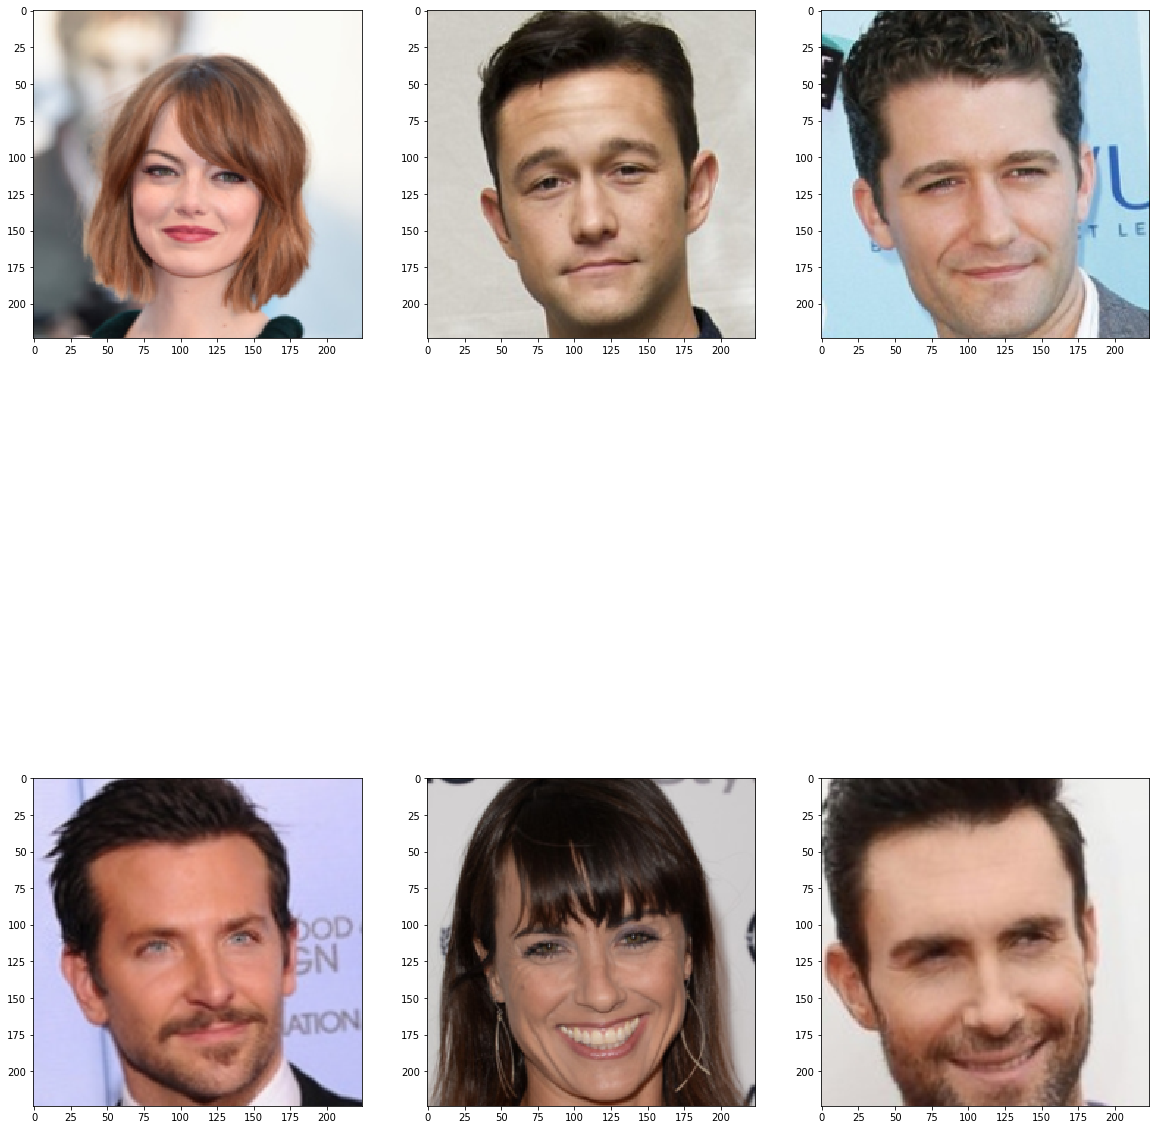

In [43]:
transformed_imgs = []
for i in faces:
    img = faces[i]
    eye = eyes[i]
    transformed = transform_face(img, eye)
    transformed_imgs.append(transformed)
    
visualize(transformed_imgs)